In [1]:
import laspy
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize, shapes
from rasterio.transform import from_bounds
from rasterio.crs import CRS
from rasterio.enums import Resampling
import folium
import pickle


from pathlib import Path
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from alphashape import alphashape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
import geoalchemy2
import getpass

In [50]:
# INPUTS
IN_SAMPLE_LAS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\las\extracted_lidar.las")
IN_AOI_LAS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\las\lidar_AOI.las")
IN_IMAGE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\Fotos aereas\sentinel_lava.tif")
DESIRED_CRS = CRS.from_epsg(32628)
RESOLUTION = 1.75
IN_RASTER_BEFORE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\DTM\before\before_MDT02.tiff")
IN_RASTER_AFTER = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\DTM\after\Cumbre_Vieja_DSM_SfM_January_2022_20cm_REGCAN95.tif")

# OUTPUTS
OUT_RASTER_BUILDINGS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\buildings.tif")
OUT_RASTER_LAVA_CLASSIFICATION = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\classified_lava.tif")
OUT_SHAPEFILE_BUILDINGS_POLYGON = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\buildings_polygon.shp")
OUT_SHAPEFILE_BUILDINGS_POINT = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\buildings_points.shp")
# OUT_SHAPEFILE_BUILDINGS_POLYGON_FILTERED = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\buildings_polygons_filtered.shp")
# OUT_SHAPEFILE_BUILDINGS_POINT_FILTERED = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\buildinsg_points_filtered.shp")
OUT_SHAPEFILE_BUILDINGS_DBSCAN = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_dbscan\buildings_dbscan.shp")
OUT_SHAPEFILE_LAVAFLOW = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\lava_flow\lava_flow.shp")
OUT_SHAPEFILE_AFFECTED_BUILDINGS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\affected_buildings\affected_buildings_area.shp")
OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\affected_buildings\affected_buildings_point.shp")
OUT_RF_MODEL = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\random_forest_classifier\RF_model.pickle")
OUT_RASTER_DIFFERENCE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\DTM_difference\difference.tif")

In [2]:
# DEFINE FUNCTIONS:

def import_las_to_geoDataFrame(in_file, desired_crs):
    """
    Imports a LAS file and converts it into a Pandas GeoDataFrame.

    Parameters:
        in_file (str): The path to the LAS file to be imported.

    Returns:
        lidar_gdf (GeoDataFrame): A GeoDataFrame containing the LAS data
                                  with x, y, z, classification and geometry columns.
    """
    print("Loading LAS file...")
    las_data = laspy.read(in_file)
    x = np.array(las_data.x)
    y = np.array(las_data.y)
    z = np.array(las_data.z)
    c = np.array(las_data.classification)
    
    df = pd.DataFrame({'x': x,'y': y,'z': z,'classification': c})
    df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1)
    lidar_gdf = gpd.GeoDataFrame(df, crs=DESIRED_CRS, geometry=df['geometry']) 
    print("LAS file loaded to a Pandas GeoDataFrame.")
    return lidar_gdf

def random_forest_classifier(lidar_gdf, model_output_path):
    """
    Trains a Random Forest Classifier using lidar data and saves the model to a pickle file.

    Parameters:
        lidar_gdf (GeoDataFrame): A GeoDataFrame containing lidar data with columns for x, y, z,
                                  classification and geometry.
        model_output_path (str): The path to save the trained Random Forest model as a pickle file.

    Returns:
        lidar_classified_gdf (GeoDataFrame): A copy of the input GeoDataFrame with an additional
                                             column ('predicted_classification') that contains the
                                             predicted classifications from the Random Forest model.
    """
    X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
    y = lidar_gdf['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)   
    rf_classifier = RandomForestClassifier()
    print("Fitting Random Forest Classifier Model...")
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest accuracy: {accuracy}")
    with open(model_output_path, 'wb') as file:
        pickle.dump(rf_classifier, file)    
    print(f'Random Forest Model Pickle File saved: {model_output_path}')
    
    lidar_classified_gdf = lidar_gdf.copy()
    lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)
    
    return lidar_classified_gdf
    
def buildings_to_polygon(lidar_classified_gdf, resolution, desired_crs, output_raster, output_shape_buildings, output_shape_buildings_points):
    """
    Converts classified building points from a lidar GeoDataFrame into polygons and saves them as an ESRI Shapefile.

    Parameters:
        lidar_classified_gdf (GeoDataFrame): A GeoDataFrame containing classified lidar data with columns
                                             for x, y, z, classification, geometry and predicted_classification.
        resolution (float): The resolution (pixel size) to be used for rasterization.
        desired_crs (str): The desired CRS (Coordinate Reference System) for the output GeoDataFrames.
        output_raster (str): The path to save the rasterized building points as a GeoTIFF raster file.
        output_shape_buildings (str): The path to save the buildings polygons as an ESRI Shapefile.
        output_shape_buildings_points (str): The path to save the buildings centroids as an ESRI Shapefile.

    Returns:
        buildings_filtered_gdf (GeoDataFrame): A GeoDataFrame containing the buildings polygons
                                               with columns for polygons, centroids and area.
    """    
    building_points_gdf = lidar_classified_gdf[lidar_classified_gdf['predicted_classification']==6]
    bounds = building_points_gdf.total_bounds
    rows = int((bounds[3] - bounds[1]) / resolution)
    cols = int((bounds[2] - bounds[0]) / resolution)

    output_profile = {
        'driver': 'GTiff',
        'dtype': np.uint8,
        'count': 1,
        'width': cols,
        'height': rows,
        'transform': from_bounds(*bounds, cols, rows),
        'crs': DESIRED_CRS,
    }

    raster = np.zeros((output_profile['height'], output_profile['width']), dtype=np.uint8)

    rasterized = rasterize(
        shapes=building_points_gdf.geometry,
        out=raster,
        transform=output_profile['transform'],
        fill=0,
        default_value=255,
        dtype=np.uint8,
    )

    with rasterio.open(output_raster, 'w', **output_profile) as dst:
        dst.write(rasterized, 1)
        
    with rasterio.open(output_raster) as src:
        raster = src.read(1)  
        transform = src.transform 
    print(f'Building Raster saved: {output_raster}')
    
    polygons = []
    for polygon, value in shapes(raster, mask=raster == 255, transform=transform):
        if value == 255:
            polygons.append(shape(polygon))
            
    buildings_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=desired_crs)
    buildings_gdf = buildings_gdf.rename_geometry('polygons')
    buildings_gdf['centroids'] = buildings_gdf.centroid
    buildings_gdf['area'] = buildings_gdf.area
    
    buildings_filtered_gdf = buildings_gdf[buildings_gdf.area > 10]
    buildings_filtered_gdf['polygons'].to_file(output_shape_buildings, driver='ESRI Shapefile')
    buildings_filtered_gdf['centroids'].to_file(output_shape_buildings_points, driver='ESRI Shapefile')
    print(f'Building Shapefiles saved: {output_shape_buildings}, {output_shape_buildings_points}')
    return buildings_filtered_gdf

def buildings_to_polygon_dbscan(lidar_classified_gdf, desired_crs, out_shapefile_buildings_dbscan):
    
    gdf_dbscan = lidar_classified_gdf[lidar_classified_gdf['predicted_classification'] == 6]
    gdf_dbscan = gdf_dbscan[['x','y','geometry']]
    coords = gdf_dbscan[['x', 'y']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    eps = 0.1 
    min_samples = 5  
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(coords_scaled)

    gdf_dbscan['cluster'] = clusters

    polygons = []

    gdf_clusters = gdf_dbscan[gdf_dbscan['cluster'] != -1]

    for cluster_label in gdf_clusters['cluster'].unique():
        cluster_coords = gdf_clusters.loc[gdf_clusters['cluster'] == cluster_label, ['x', 'y']].values
        outline_polygon = Polygon(cluster_coords).convex_hull
        polygons.append(outline_polygon)

    buildings_polygon_gdf = gpd.GeoDataFrame(geometry=polygons, index=gdf_clusters['cluster'].unique(), crs=desired_crs)

    buildings_polygon_gdf.to_file(out_shapefile_buildings_dbscan, driver='ESRI Shapefile')
    print(f'Building Shapefiles saved: {out_shapefile_buildings_dbscan}')
    return buildings_polygon_gdf

def lava_cluster_plotter(in_image, out_raster_lava_classification):
    """
    Perform K-means clustering on a satellite image and save the cluster image as a GeoTIFF file.

    Parameters:
        in_image (str): Path to the input raster image.
        out_raster_lava_classification (str): Path to save the output cluster image as a GeoTIFF file.

    Returns:
        lava_classified_gdf (GeoDataFrame): GeoDataFrame containing the K-Means cluster assignments.
    """    
    image = rasterio.open(in_image)
    band_index = 1  
    band = image.read(band_index)

    X = band.reshape((-1,1))

    k_means = KMeans(n_clusters=10)
    k_means.fit(X)

    clusters = k_means.labels_
    clusters = clusters.reshape(band.shape)
    
    coords = []
    for i in range(image.height):
        for j in range(image.width):
            lon, lat = image.xy(i, j)
            coords.append(Point(lon, lat))
        
    lava_classified_df = pd.DataFrame({'geometry': coords, 'cluster_kmeans': clusters.flatten()})

    lava_classified_gdf = gpd.GeoDataFrame(lava_classified_df, crs=image.crs)

    metadata = image.meta
    metadata.update({
        'count': 1,  
        'dtype': rasterio.uint8, 
        'compress': 'lzw',  
         'nodata': 0,  
    })

    with rasterio.open(out_raster_lava_classification, 'w', **metadata) as dst:
        dst.write(clusters.astype(rasterio.uint8), 1)
    print(f'Lava Clusters GeoTIFF file saved: {out_raster_lava_classification}')

    plt.figure(figsize=(20,20))
    plt.imshow(clusters, cmap="Set1")
    plt.colorbar(label='Classification')
    plt.show()
    
    return lava_classified_gdf   
    
def lava_extractor(lava_classified_gdf, out_shapefile_lavaflow, OUT_SHAPEFILE_LAVAFLOW):
    """
    Extract a lava flow polygon from a cluster in a GeoDataFrame using DBSCAN clustering.

    Parameters:
        lava_classified_gdf (GeoDataFrame): GeoDataFrame containing cluster assignments and coordinates.
        out_shapefile_lavaflow (str): Path to save the output shapefile containing the lava flow polygon.

    Returns:
        lava_polygon_gdf (GeoDataFrame): GeoDataFrame containing the extracted lava flow polygon.
    """
    cluster_number = int(input('Enter the K-Means cluster number representing the lava flow:'))
    lava_gdf = lava_classified_gdf[lava_classified_gdf['cluster_kmeans'] == cluster_number].copy()
    lava_gdf['x'] = lava_gdf['geometry'].x
    lava_gdf['y'] = lava_gdf['geometry'].y
    
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=100, min_samples=100)
    labels = dbscan.fit_predict(lava_gdf[['x', 'y']])
    
    # Assign cluster labels to the original GeoDataFrame
    lava_gdf['cluster_dbscan'] = labels
    
    # Visualize the cluster labels
    fig, ax = plt.subplots(figsize=(10, 10))
    lava_gdf.plot(column='cluster_dbscan', cmap='Set1', ax=ax, legend=True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('DBSCAN Clustering')
    plt.show()
    
    final_lava_gdf = lava_gdf[lava_gdf['cluster_dbscan'] == 0]
    
    # Visualize the cluster labels
    fig, ax = plt.subplots(figsize=(10, 10))
    final_lava_gdf.plot(column='cluster_dbscan', cmap='Set1', ax=ax, legend=True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Extracted Lava Flow')
    plt.show()
    
    # Extract the coordinates from the geometry column
    points = final_lava_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
    # Compute the concave hull using alpha shape
    alpha = 0.1  # Adjust the alpha value to control the level of concavity
    concave_hull = alphashape(points, alpha)
    
    # Create a new GeoDataFrame for the concave hull polygon
    lava_polygon_gdf = gpd.GeoDataFrame(geometry=[concave_hull], crs=lava_classified_gdf.crs)
    
    lava_polygon_gdf.to_file(out_shapefile_lavaflow, driver='ESRI Shapefile')
    print(f'Lava Flow Shapefile saved: {out_shapefile_lavaflow}')
    
    return lava_polygon_gdf

def affected_buildings(buildings_filtered_gdf, lava_polygon_gdf, out_shapefile_affected_buildings, out_shapefile_affected_buildings_points):
    """
    Identify the buildings affected by a lava flow and save them as an ESRI Shapefile.

    Parameters:
        buildings_filtered_gdf (GeoDataFrame): GeoDataFrame containing the buildings to be analyzed.
        lava_polygon_gdf (GeoDataFrame): GeoDataFrame representing the lava flow polygon.
        out_shapefile_affected_buildings (str): Path to save the output ESRI Shapefile containing the affected building polygons.
        out_shapefile_affected_buildings_points (str): Path to save the output ESRI Shapefile containing the centroids of the affected buildings.

    Returns:
        buildings_w_lava_gdf (GeoDataFrame): GeoDataFrame containing the affected buildings.
    """
    buildings_w_lava_gdf = gpd.sjoin(buildings_filtered_gdf, lava_polygon_gdf, predicate="intersects")
    print(f"Total affected buildings: {len(buildings_w_lava_gdf)}")
    buildings_w_lava_gdf['polygons'].to_file(out_shapefile_affected_buildings, driver='ESRI Shapefile')
    buildings_w_lava_gdf['centroids'].to_file(out_shapefile_affected_buildings_points, driver='ESRI Shapefile')
    print(f'Affected Buildings Shapefiles saved: {out_shapefile_affected_buildings} , {out_shapefile_affected_buildings_points}')
    return buildings_w_lava_gdf    

def elevation_change(in_raster_before, in_raster_after, out_raster_difference):
    """
    Calculate the elevation change between two input raster files and save the difference as a GeoTIFF.

    Parameters:
        in_raster_before (Path): Path to the input raster file representing elevation data before the event.
        in_raster_after (Path): Path to the input raster file representing elevation data after the event.
        out_raster_difference (Path): Path to save the output GeoTIFF file containing the elevation change.

    """
    src1 = rasterio.open(in_raster_before)
    src2 = rasterio.open(in_raster_after)

    # Reproject the second raster to match the resolution and extent of the first raster
    data2, _ = rasterio.warp.reproject(
        source=rasterio.band(src2, 1),
        destination=np.empty_like(src1.read(1)),
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=src1.transform,
        dst_crs=src1.crs,
        resampling=Resampling.bilinear)

    # Read the input raster data
    data1 = src1.read(1)

    # Compute the difference between the rasters
    diff = data1 - data2

    # Replace inf and NaN values with a valid nodata value
    diff[np.isinf(diff) | np.isnan(diff)] = src1.nodata

    # Prepare the output GeoTIFF file
    output_profile = src1.profile
    output_profile.update(count=1)  # Update band count

    # Create the output file
    with rasterio.open(out_raster_difference, 'w', **output_profile) as dst:
        # Write the difference data to the output file
        dst.write(diff, 1)
    print(f'Elevation Change GeoTIFF saved: {out_raster_difference}')

    # Close the input files
    src1.close()
    src2.close()
    
def import_geoDataFrame_to_database(input_gdf,table_name):
    """
    Imports a Pandas GeoDataFrame into a PostGIS database table.

    Parameters:
        input_gdf (GeoDataFrame): The Pandas GeoDataFrame containing the spatial data to be imported.
        table_name (str): The name of the PostGIS database table to import the data into.

    Returns:
        None
    """
    password = getpass.getpass('Enter the database password:')
    engine = create_engine('postgresql://postgres:' + password + '@localhost:5432/la_palma')
    input_gdf.to_postgis(table_name, con=engine)
    print(f'GeoDataFrame {input_gdf} saved to the PostGIS database table {table_name}')
    
def import_raster_to_database(input_raster, table_name):
    """
    Imports a raster dataset into a PostGIS database table.

    Parameters:
        input_raster (str): The file path to the raster dataset to be imported.
        table_name (str): The name of the PostGIS database table to import the raster into.

    Returns:
        None

    """
    host = 'localhost'
    port = '5432'
    database = 'la_palma'
    username = 'postgres'
    password = getpass.getpass('Enter the database password:')

    # Define the command to run, including any necessary arguments
    command_raster2pgsql = [
        r"C:\Program Files\PostgreSQL\15\bin\raster2pgsql.exe", '-I', '-C', '-M', input_raster
    ]
    command_psql = [
        r"C:\Program Files\PostgreSQL\15\bin\psql.exe", '-h', host, '-p', port, '-d', database, '-U', username,
        '--password', password
    ]

    # Run the raster2pgsql command and capture the output
    process_raster2pgsql = subprocess.Popen(command_raster2pgsql, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output_raster2pgsql, error_raster2pgsql = process_raster2pgsql.communicate()

    # Check the return code of raster2pgsql command
    if process_raster2pgsql.returncode == 0:
        # Run the psql command and capture the output
        process_psql = subprocess.Popen(command_psql, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output_psql, error_psql = process_psql.communicate(input=output_raster2pgsql)
        
        # Check the return code of psql command
        if process_psql.returncode == 0:
            print(f'Raster file {input_raster} saved to the PostGIS database table {table_name}')
        else:
            print('An error occurred in psql command:', error_psql.decode())
    else:
        print('An error occurred in raster2pgsql command:', error_raster2pgsql.decode())
        
def main():
    """
    Executes the main workflow for processing lidar and image data.

    Parameters:
        None

    Returns:
        None
    """
    lidar_gdf = import_las_to_geoDataFrame(IN_AOI_LAS, DESIRED_CRS)
    lidar_classified_gdf = random_forest_classifier(lidar_gdf, OUT_RF_MODEL)
    buildings_filtered_gdf = buildings_to_polygon(lidar_classified_gdf, RESOLUTION, DESIRED_CRS, OUT_RASTER_BUILDINGS, OUT_SHAPEFILE_BUILDINGS_POLYGON, OUT_SHAPEFILE_BUILDINGS_POINT)
    lava_classified_gdf = lava_cluster_plotter(IN_IMAGE, OUT_RASTER_LAVA_CLASSIFICATION) 
    lava_polygon_gdf = lava_extractor(lava_classified_gdf, OUT_SHAPEFILE_LAVAFLOW)
    buildings_w_lava_gdf = affected_buildings(buildings_filtered_gdf, lava_classified_gdf, OUT_SHAPEFILE_AFFECTED_BUILDINGS, OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS)
    elevation_change(IN_RASTER_BEFORE, IN_RASTER_AFTER, OUT_RASTER_DIFFERENCE)
    import_geoDataFrame_to_database(buildings_filtered_gdf, 'buildings')
    import_geoDataFrame_to_database(lava_polygon_gdf, 'lava_flow')
    import_geoDataFrame_to_database(buildings_w_lava_gdf, 'affected_buildings')
    # import_raster_to_database(OUT_RASTER_DIFFERENCE, 'elevation_raster')    

In [5]:
# MAIN FUNCTION TEST

# print('Testing main function...')
# lidar_gdf = import_las_to_geoDataFrame(IN_AOI_LAS, DESIRED_CRS)
# lidar_classified_gdf = random_forest_classifier(lidar_gdf, OUT_RF_MODEL)
# buildings_filtered_gdf = buildings_to_polygon(lidar_classified_gdf, RESOLUTION, DESIRED_CRS, OUT_RASTER_BUILDINGS, OUT_SHAPEFILE_BUILDINGS_POLYGON, OUT_SHAPEFILE_BUILDINGS_POINT)
# lava_classified_gdf = lava_cluster_plotter(IN_IMAGE, OUT_RASTER_LAVA_CLASSIFICATION) 
# lava_polygon_gdf = lava_extractor(lava_classified_gdf, OUT_SHAPEFILE_LAVAFLOW)
# buildings_w_lava_gdf = affected_buildings(buildings_filtered_gdf, lava_classified_gdf, OUT_SHAPEFILE_AFFECTED_BUILDINGS, OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS)
# elevation_change(IN_RASTER_BEFORE, IN_RASTER_AFTER, OUT_RASTER_DIFFERENCE)
# import_geoDataFrame_to_database(buildings_filtered_gdf, 'buildings')
# import_geoDataFrame_to_database(lava_polygon_gdf, 'lava_flow')
# import_geoDataFrame_to_database(buildings_w_lava_gdf, 'affected_buildings')
# print('Main function test completed.')

In [31]:
# MANUAL WORKFLOW

# 1. IMPORT LAS TO GEODATAFRAME:
print("Loading LAS file...")
las_data = laspy.read(IN_SAMPLE_LAS)
x = np.array(las_data.x)
y = np.array(las_data.y)
z = np.array(las_data.z)
c = np.array(las_data.classification)
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z,
    'classification': c,   
})
df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1)
lidar_gdf = gpd.GeoDataFrame(df, crs=DESIRED_CRS, geometry=df['geometry'])
print("LAS file loaded")

In [32]:
lidar_gdf

,x,y,z,classification,geometry
0,214897.42,3168508.29,196.63,1,POINT (214897.420 3168508.290)
1,214963.63,3168562.44,215.30,2,POINT (214963.630 3168562.440)
2,214991.30,3168469.24,216.00,3,POINT (214991.300 3168469.240)
3,214995.61,3168604.28,227.51,2,POINT (214995.610 3168604.280)
4,214906.41,3168485.27,204.54,3,POINT (214906.410 3168485.270)
...,...,...,...,...,...
36575,214999.04,3168630.44,239.56,2,POINT (214999.040 3168630.440)
36576,214994.81,3168627.87,238.60,3,POINT (214994.810 3168627.870)
36577,214992.51,3168631.03,239.51,2,POINT (214992.510 3168631.030)
36578,214999.38,3168626.41,237.88,2,POINT (214999.380 3168626.410)


In [103]:
# fig, ax = plt.subplots(figsize=(10, 8)) 
# gdf.plot(ax=ax, column='classification', cmap='rainbow', legend=True,  markersize=3)

# plt.title('Classification')  
# ax.set_xlabel('X')
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
# ax.set_ylabel('Y')

# ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# plt.show()

In [104]:
# lidar_gdf.explore(
#     column="classification", 
#     tooltip="z", 
#     popup=True,
#     cmap="Set1"  
# )

In [38]:
# 2. RANDOM FOREST CLASSIFIER.

X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
y = lidar_gdf['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy}")
with open(OUT_RF_MODEL, 'wb') as file:
        pickle.dump(rf_classifier, file)    
print(f'Random Forest Picke File saved: {OUT_RF_MODEL}')   
lidar_classified_gdf = lidar_gdf.copy()
lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)    

In [12]:
# HYPERPARAMETER TUNING USING GRID SEARCH
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [5, 10],
#     'min_samples_split': [2, 5, 10]
# }

# rf_classifier = RandomForestClassifier(random_state=100)
# grid_search = GridSearchCV(rf_classifier, param_grid,scoring='accuracy', cv=5)
# grid_search.fit(X_train, y_train)
# best_score = grid_search.best_score_
# best_params = grid_search.best_params_
# print("Best Score:", best_score)
# print("Best Parameters:", best_params)

# best_model = RandomForestClassifier(**best_params)
# best_model.fit(X_train, y_train)


# # Predict the classifications for the test set
# y_pred = best_model.predict(X_test)

# lidar_gdf['predicted_classification'] = best_model.predict(X)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

C:\Users\garpa\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Score: 0.7758678883500163
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [40]:
# Apply model from pickle file.

# with open(OUT_RF_MODEL, 'rb') as file:
#     rf_classifier = pickle.load(file)
    
# lidar_gdf['predicted_classification'] = rf_classifier.predict(X)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

Accuracy: 0.8627665390924002


In [27]:
# fig, ax = plt.subplots(figsize=(10, 8)) 
# building_gdf.plot(ax=ax, column='classification', cmap='rainbow', markersize=3)

# plt.title('Buildings')  
# ax.set_xlabel('X')
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
# ax.set_ylabel('Y')

# ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# plt.show()

In [10]:
# BUILDING TO POLYGON
building_points_gdf = lidar_classified_gdf[lidar_classified_gdf['predicted_classification']==6]
bounds = building_points_gdf.total_bounds


rows = int((bounds[3] - bounds[1]) / RESOLUTION)
cols = int((bounds[2] - bounds[0]) / RESOLUTION)

output_profile = {
    'driver': 'GTiff',
    'dtype': np.uint8,
    'count': 1,
    'width': cols,
    'height': rows,
    'transform': from_bounds(*bounds, cols, rows),
    'crs': DESIRED_CRS,
}

raster = np.zeros((output_profile['height'], output_profile['width']), dtype=np.uint8)
# Rasterize the points in the GeoDataFrame
rasterized = rasterize(
    shapes=building_points_gdf.geometry,
    out=raster,
    transform=output_profile['transform'],
    fill=0,
    default_value=255,
    dtype=np.uint8,
)

with rasterio.open(OUT_RASTER_BUILDINGS, 'w', **output_profile) as dst:
    dst.write(rasterized, 1)
    
with rasterio.open(OUT_RASTER_BUILDINGS) as src:
    raster = src.read(1)  
    transform = src.transform 
print(f'Building Raster saved: {OUT_RASTER_BUILDINGS}')

polygons = []
for polygon, value in shapes(raster, mask=raster == 255, transform=transform):
    if value == 255:
        polygons.append(shape(polygon))

buildings_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=desired_crs)
buildings_gdf = buildings_gdf.rename_geometry('polygons')
buildings_gdf['centroids'] = buildings_gdf.centroid
buildings_gdf['area'] = buildings_gdf.area

buildings_filtered_gdf = buildings_gdf[buildings_gdf.area > 20]
buildings_filtered_gdf['polygons'].to_file(OUT_SHAPEFILE_BUILDINGS_POLYGON_FILTERED, driver='ESRI Shapefile')
buildings_filtered_gdf['centroids'].to_file(OUT_SHAPEFILE_BUILDINGS_POINT_FILTERED, driver='ESRI Shapefile')
print(f'Building Shapefiles saved: {OUT_SHAPEFILE_BUILDINGS_POLYGON_FILTERED}, {OUT_SHAPEFILE_BUILDINGS_POINT_FILTERED}')

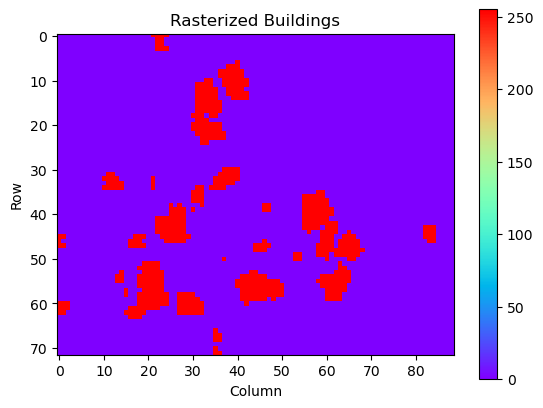

In [11]:
plt.imshow(rasterized, cmap='rainbow')
plt.title('Rasterized Buildings')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar()
plt.show()

In [110]:
buildings_filtered_gdf

,geometry
0,"POLYGON ((214927.967 3168608.850, 214927.967 3..."
1,"POLYGON ((214966.010 3168596.703, 214968.012 3..."
2,"POLYGON ((214951.994 3168588.606, 214955.999 3..."
3,"POLYGON ((214927.967 3168544.068, 214927.967 3..."
4,"POLYGON ((214907.945 3168546.092, 214911.949 3..."
5,"POLYGON ((214960.003 3168548.117, 214968.012 3..."
6,"POLYGON ((214947.990 3168540.019, 214951.994 3..."
7,"POLYGON ((214978.023 3168531.921, 214978.023 3..."
8,"POLYGON ((214945.987 3168529.897, 214945.987 3..."
9,"POLYGON ((214935.976 3168531.921, 214937.978 3..."


In [12]:
buildings_filtered_gdf.explore(

)

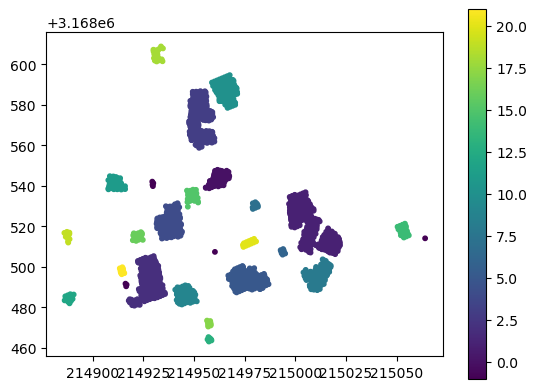

In [18]:
# BUILDINGS TO POLYGON DBSCAN

# gdf_dbscan = lidar_gdf[lidar_gdf['classification'] == 6]
# gdf_dbscan = gdf_dbscan[['x','y','geometry']]
# coords = gdf_dbscan[['x', 'y']].values
# scaler = StandardScaler()
# coords_scaled = scaler.fit_transform(coords)

# # Apply DBSCAN clustering
# eps = 0.1  # The maximum distance between two samples to be considered in the same neighborhood
# min_samples = 5  # The minimum number of samples in a neighborhood for a point to be considered as a core point
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# clusters = dbscan.fit_predict(coords_scaled)


# # Add the cluster labels to the GeoDataFrame
# gdf_dbscan['cluster'] = clusters

# # Visualize the clusters
# gdf_dbscan.plot(column='cluster', cmap='viridis', markersize=10, legend=True)

# # Create polygons
# polygons = []

# gdf_clusters = gdf_dbscan[gdf_dbscan['cluster'] != -1]

# for cluster_label in gdf_clusters['cluster'].unique():
#     cluster_coords = gdf_clusters.loc[gdf_clusters['cluster'] == cluster_label, ['x', 'y']].values
#     outline_polygon = Polygon(cluster_coords).convex_hull
#     polygons.append(outline_polygon)

# buildings_polygon_gdf = gpd.GeoDataFrame(geometry=polygons, index=gdf_clusters['cluster'].unique(), crs=DESIRED_CRS)

# buildings_polygon_gdf.to_file(OUT_SHAPE2)

In [19]:
gdf_dbscan.explore(
    column="cluster", 
    tooltip="cluster", 
    popup=True,
    cmap="Set1"  
)

In [20]:
buildings_polygon_gdf

,geometry
0,"POLYGON ((214957.470 3168538.790, 214955.820 3..."
1,"POLYGON ((215019.690 3168506.250, 215007.530 3..."
2,"POLYGON ((214920.510 3168480.800, 214919.430 3..."
3,"POLYGON ((214952.470 3168558.780, 214950.700 3..."
4,"POLYGON ((214934.120 3168513.970, 214931.770 3..."
5,"POLYGON ((214971.010 3168487.350, 214970.380 3..."
6,"POLYGON ((214993.720 3168506.010, 214993.230 3..."
7,"POLYGON ((214979.030 3168528.600, 214978.910 3..."
8,"POLYGON ((215010.840 3168488.470, 215009.180 3..."
9,"POLYGON ((214943.950 3168481.380, 214942.760 3..."


In [21]:
buildings_polygon_gdf.explore(
    cmap="Set1"    
)

In [22]:
# m = folium.Map(location=[28.6123140,-17.9150801], zoom_start=50)


m = buildings_polygon_gdf.explore(
    color= "blue",
    tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="DBSCAN"
)
    
buildings_rasterize_gdf.explore(
    m=m,  # pass the map object
    color="red",  # use red color on all points
    tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="RASTERIZE"
)
folium.LayerControl().add_to(m)  # use folium to add layer control

m  

GeoTIFF file saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\classified_lava.tif


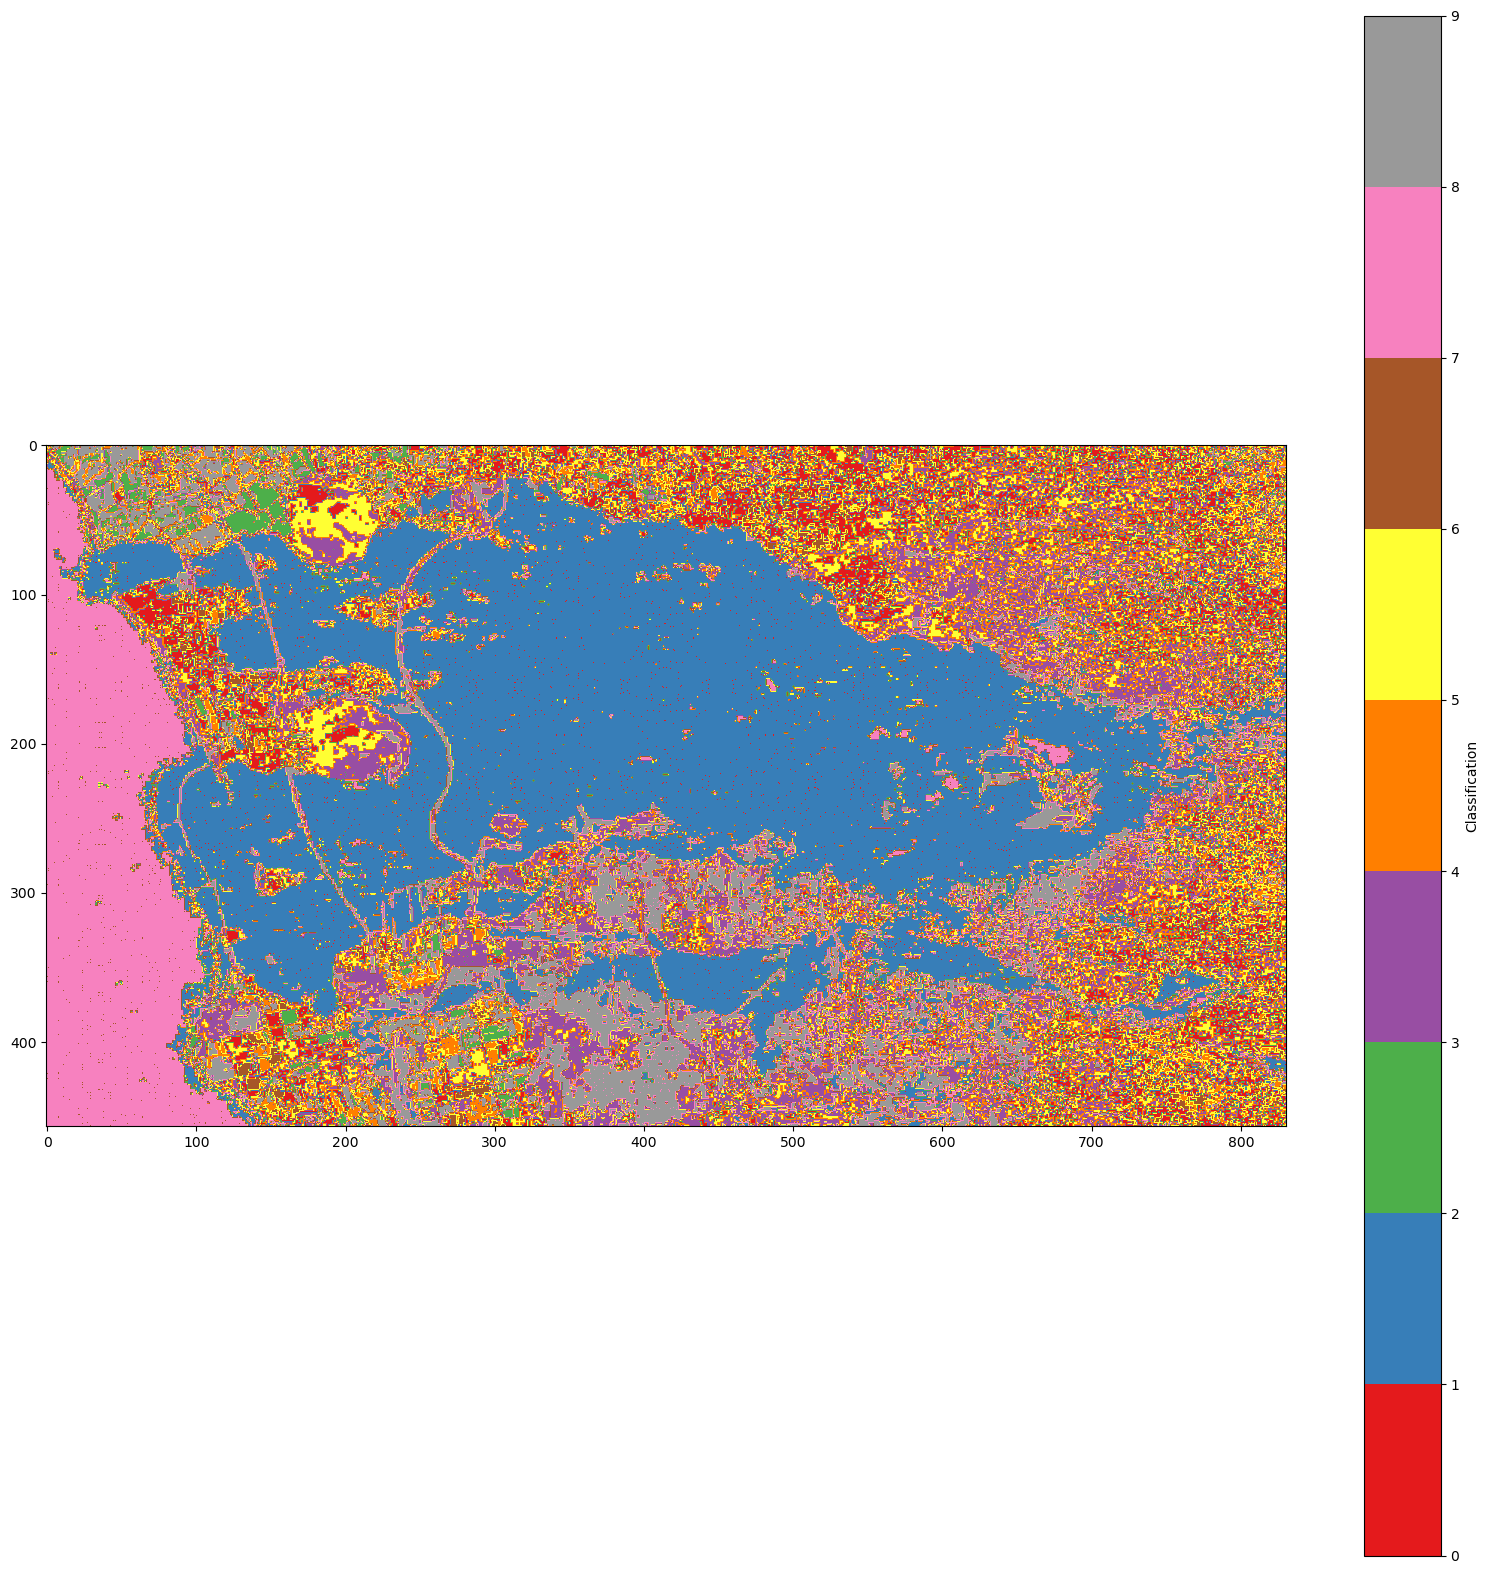

,geometry,cluster_kmeans
0,POINT (212870.4081518426 3170905),8
1,POINT (212880.4081518426 3170905),5
2,POINT (212890.4081518426 3170905),4
3,POINT (212900.4081518426 3170905),2
4,POINT (212910.4081518426 3170905),2
...,...,...
379762,POINT (221130.4081518426 3166345),6
379763,POINT (221140.4081518426 3166345),0
379764,POINT (221150.4081518426 3166345),5
379765,POINT (221160.4081518426 3166345),5


In [23]:
# LAVA FLOW EXTRACTOR

image = rasterio.open(IN_IMAGE)
band_index = 1  
band = image.read(band_index)

X = band.reshape((-1,1))

k_means = KMeans(n_clusters=10)
k_means.fit(X)

clusters = k_means.labels_
clusters = clusters.reshape(band.shape)

# Define the metadata for the new GeoTIFF file
metadata = image.meta
metadata.update({
    'count': 1,  # Number of bands in the output image
    'dtype': rasterio.uint8,  # Data type of the output image
    'compress': 'lzw',  # Compression method for the output image
     'nodata': 0,  # NoData value for the output image
})

# Write the cluster image to the new GeoTIFF file
with rasterio.open(OUT_RASTER1, 'w', **metadata) as dst:
    dst.write(clusters.astype(rasterio.uint8), 1)
    
print('GeoTIFF file saved:', OUT_RASTER1)

plt.figure(figsize=(20,20))
plt.imshow(clusters, cmap="Set1")
plt.colorbar(label='Classification')
plt.show()


coords = []
for i in range(image.height):
    for j in range(image.width):
        lon, lat = image.xy(i, j)
        coords.append(Point(lon, lat))
        
        
lava_classified_df = pd.DataFrame({'geometry': coords, 'cluster_kmeans': clusters.flatten()})
lava_classified_df

In [24]:
# classified_gdf = gpd.GeoDataFrame(classified_df, crs=DESIRED_CRS)
# lava_gdf = classified_gdf[classified_gdf['cluster_kmeans']==1]

C:\Users\garpa\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\garpa\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\garpa\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

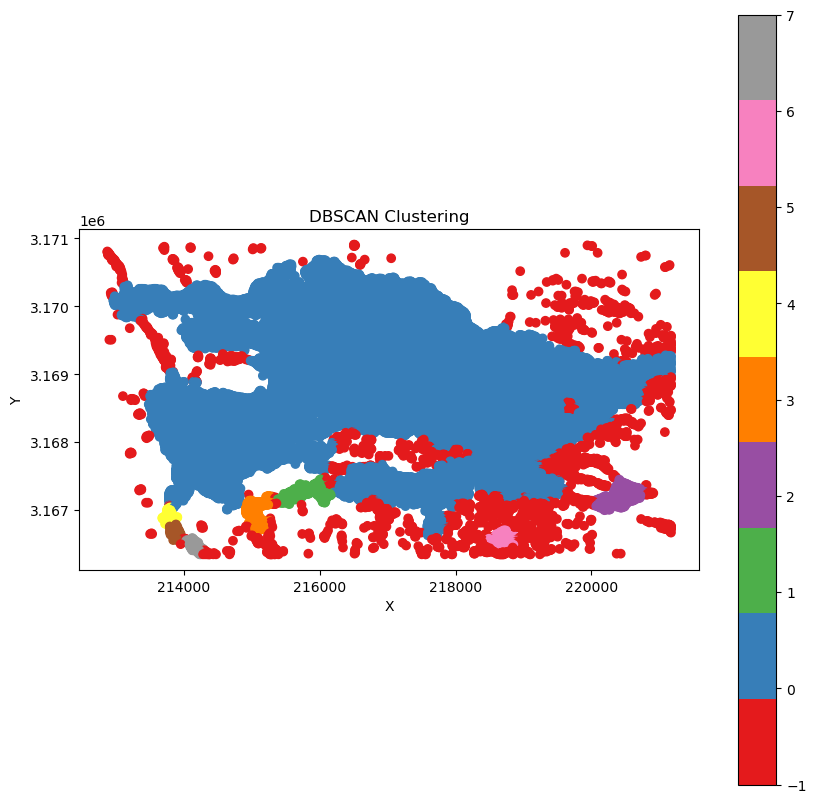

In [25]:
# LAVA EXTRACTOR
lava_gdf = lava_classified_gdf[lava_classified_gdf['cluster_kmeans'] == cluster_number].copy()
# Extract coordinates from the 'geometry' column
lava_gdf['x'] = lava_gdf['geometry'].x
lava_gdf['y'] = lava_gdf['geometry'].y

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=100, min_samples=100)
labels = dbscan.fit_predict(lava_gdf[['x', 'y']])

# Assign cluster labels to the original GeoDataFrame
lava_gdf['dbscan_cluster'] = labels

# Visualize the cluster labels
fig, ax = plt.subplots(figsize=(10, 10))
lava_gdf.plot(column='dbscan_cluster', cmap='Set1', ax=ax, legend=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering')
plt.show()


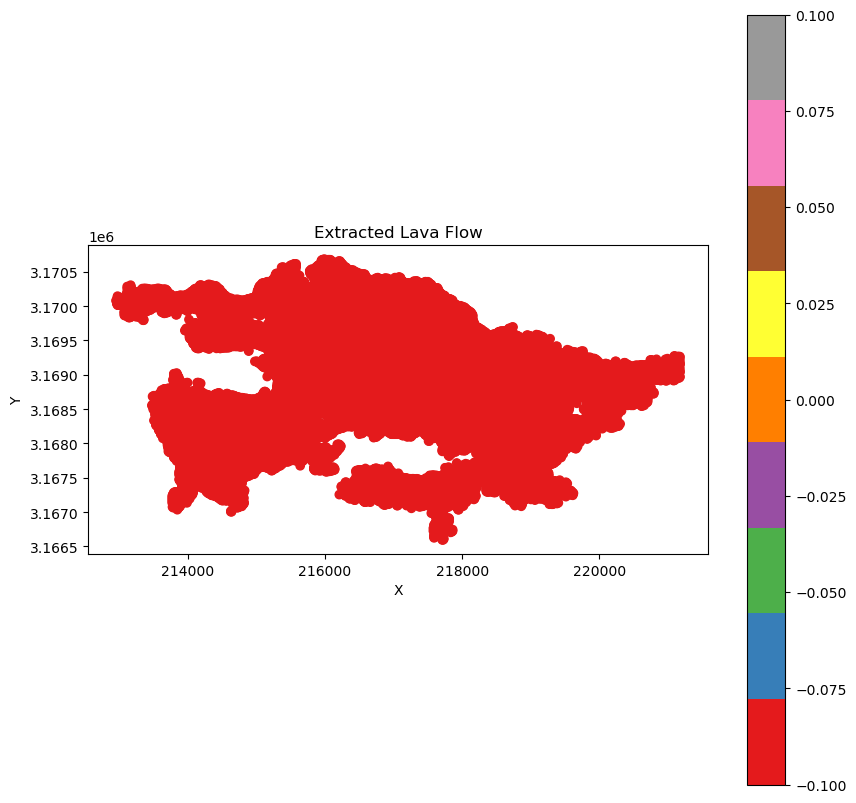

In [26]:
final_lava_gdf = lava_gdf[lava_gdf['dbscan_cluster']==0]

# Visualize the cluster labels
fig, ax = plt.subplots(figsize=(10, 10))
final_lava_gdf.plot(column='dbscan_cluster', cmap='Set1', ax=ax, legend=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Extracted Lava Flow')
plt.show()


In [32]:
# Extract the coordinates from the geometry column
points = final_lava_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

# Compute the concave hull using alpha shape
alpha = 0.1  # Adjust the alpha value to control the level of concavity
concave_hull = alphashape(points, alpha)

# Create a new GeoDataFrame for the concave hull polygon
lava_polygon_gdf = gpd.GeoDataFrame(geometry=[concave_hull], crs=DESIRED_CRS)
lava_polygon_gdf.to_file(OUT_SHAPEFILE_LAVAFLOW, driver='ESRI Shapefile')
print(f'Lava Flow Shapefile saved: {OUT_SHAPEFILE_LAVAFLOW}')

<AxesSubplot:>

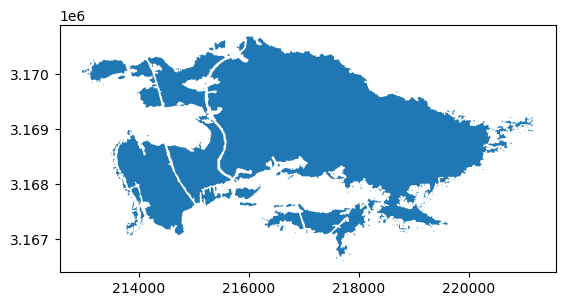

In [33]:
lava_polygon_gdf.plot()

In [34]:
lava_polygon_gdf.to_file(OUT_SHAPE3, driver='ESRI Shapefile')

In [126]:
# lava_gdf_filtered.explore(

#     cmap="Set1"  
# )

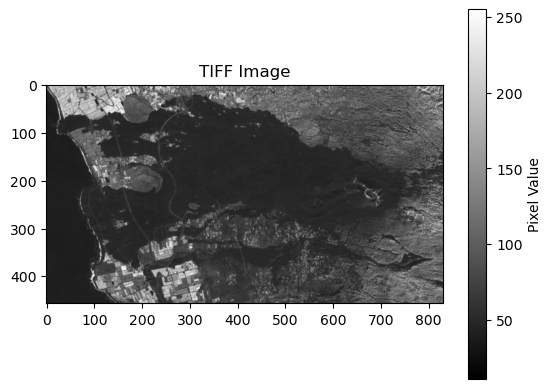

In [35]:
plt.imshow(band, cmap='gray')
plt.title('TIFF Image')
plt.colorbar(label='Pixel Value')
plt.show()

In [36]:
lava_polygon_gdf.explore(

    cmap="Set1"  
)

In [39]:
m = lava_polygon_gdf.explore(
    color="black",  # use red color on all points
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="LAVA FLOW" 
)


buildings_polygon_gdf.explore(
    m=m,
    color= "blue",
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="DBSCAN"
)
    
buildings_rasterize_gdf.explore(
    m=m,  # pass the map object
    color="red",  # use red color on all points
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="RASTERIZE"
)

folium.LayerControl().add_to(m)  # use folium to add layer control
m  

In [41]:
# AFFECTED BUILDINGS

buildings_w_lava = gpd.sjoin(buildings_filtered_gdf, lava_polygon_gdf, predicate="intersects")
print(f"Total affected buildings: {len(buildings_w_lava)}")
buildings_w_lava['polygons'].to_file(OUT_SHAPEFILE_AFFECTED_BUILDINGS, driver='ESRI Shapefile')
buildings_w_lava['centroids'].to_file(OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS, driver='ESRI Shapefile')
print(f'Affected Buildings Shapefiles saved: {OUT_SHAPEFILE_AFFECTED_BUILDINGS} , {OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS}')
buildings_w_lava  

Total affected buildings: 21


In [42]:
m = lava_polygon_gdf.explore(
    color="black",  # use red color on all points
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="LAVA FLOW" 
)


buildings_polygon_gdf.explore(
    m=m,
    color= "blue",
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="BUILDINGS"
)
    
buildings_w_lava.explore(
    m=m,  # pass the map object
    color="red",  # use red color on all points
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    name="AFFECTED BUILDINGS"
)

folium.LayerControl().add_to(m)  # use folium to add layer control
m  

In [40]:
# plt.figure(figsize=(10, 10))
# plt.scatter(x, y, s=1, c=c, cmap='rainbow')
# plt.colorbar(label='Classification')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('LAS File Visualization')
# plt.show()

In [45]:
# ELEVATION CHANGE
# Open the input GeoTIFF files
src1 = rasterio.open(in_raster_before)
src2 = rasterio.open(in_raster_after)

# Reproject the second raster to match the resolution and extent of the first raster
data2, _ = rasterio.warp.reproject(
    source=rasterio.band(src2, 1),
    destination=np.empty_like(src1.read(1)),
    src_transform=src2.transform,
    src_crs=src2.crs,
    dst_transform=src1.transform,
    dst_crs=src1.crs,
    resampling=Resampling.bilinear)

# Read the input raster data
data1 = src1.read(1)

# Compute the difference between the rasters
diff = data1 - data2

# Replace inf and NaN values with a valid nodata value
diff[np.isinf(diff) | np.isnan(diff)] = src1.nodata

# Prepare the output GeoTIFF file
output_profile = src1.profile
output_profile.update(count=1)  # Update band count

# Create the output file
with rasterio.open(out_raster_difference, 'w', **output_profile) as dst:
    # Write the difference data to the output file
    dst.write(diff, 1)
print(print(f'Elevation Change GeoTIFF saved: {out_raster_difference})

# Close the input files
src1.close()
src2.close()




C:\Users\garpa\AppData\Local\Temp\ipykernel_13388\3008831593.py:23: RuntimeWarning: overflow encountered in subtract
  diff = data1 - data2


In [56]:
elevation_change(IN_RASTER_BEFORE, IN_RASTER_AFTER, OUT_RASTER_DIFFERENCE)

C:\Users\garpa\AppData\Local\Temp\ipykernel_13388\2984082322.py:245: RuntimeWarning: overflow encountered in subtract
  diff = data1 - data2


Elevation Change GeoTIFF saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\DTM_difference\difference.tif


In [ ]:
import subprocess

# Define the command to run, including any necessary arguments
OUT_RASTER_DIFFERENCE = r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\DTM_difference\difference.tif"

# Define the database connection settings
host = 'localhost'
port = '5432'
database = 'la_palma'
username = 'postgres'
password = 'Default!'

# Define the command to run, including any necessary arguments
command_raster2pgsql = [
    r"C:\Program Files\PostgreSQL\15\bin\raster2pgsql.exe", '-I', '-C', '-M', OUT_RASTER_DIFFERENCE
]
command_psql = [
    r"C:\Program Files\PostgreSQL\15\bin\psql.exe", '-h', host, '-p', port, '-d', database, '-U', username,
    '--password', password
]

# Run the raster2pgsql command and capture the output
process_raster2pgsql = subprocess.Popen(command_raster2pgsql, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# output_raster2pgsql, error_raster2pgsql = process_raster2pgsql.communicate()

# Check the return code of raster2pgsql command
if process_raster2pgsql.returncode == 0:
    # Run the psql command and capture the output
    process_psql = subprocess.Popen(command_psql, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output_psql, error_psql = process_psql.communicate(input=output_raster2pgsql)
    
    # Check the return code of psql command
    if process_psql.returncode == 0:
        print('Raster data loaded successfully.')
    else:
        print('An error occurred in psql command:', error_psql.decode())
else:
    print('An error occurred in raster2pgsql command:', error_raster2pgsql.decode())